In [1]:
var openDigger = require('../src/open_digger');
var year = 2022, startYear = 2015;
var years = Array.from({ length: year - startYear + 1 }, (_, i) => i + startYear); // [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
var my_repo_id = 24195339;
var query = openDigger.driver.clickhouse.query;

# angular/angular 项目分析

## 1 每月新增 Star 和 Frok 的个数

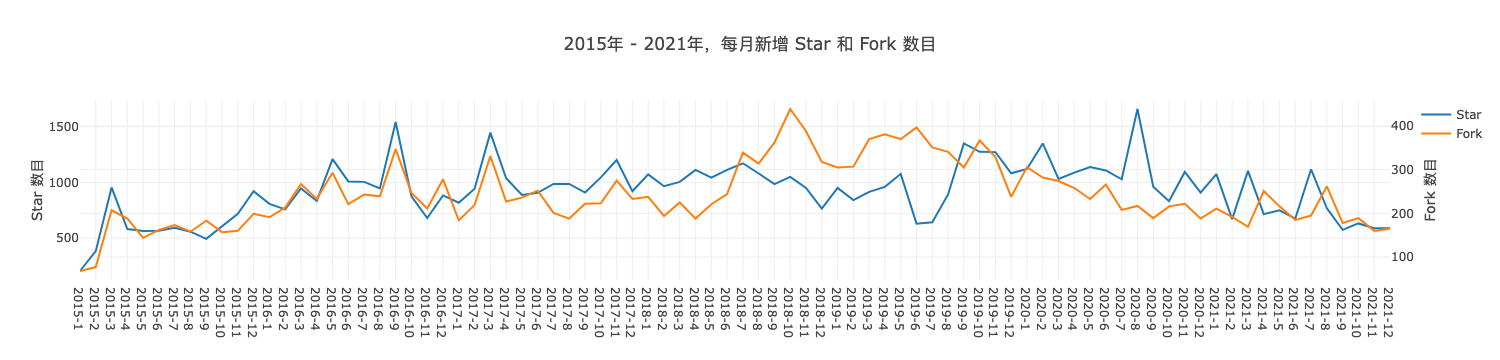

┌─────────┬───────────┬──────────────┬──────────────┐
│ (index) │   时间    │ 新增 Star 数 │ 新增 Fork 数 │
├─────────┼───────────┼──────────────┼──────────────┤
│    0    │ '2015-1'  │     205      │      68      │
│    1    │ '2015-2'  │     383      │      77      │
│    2    │ '2015-3'  │     955      │     207      │
│    3    │ '2015-4'  │     582      │     188      │
│    4    │ '2015-5'  │     565      │     144      │
│    5    │ '2015-6'  │     566      │     162      │
│    6    │ '2015-7'  │     592      │     173      │
│    7    │ '2015-8'  │     558      │     158      │
│    8    │ '2015-9'  │     494      │     183      │
│    9    │ '2015-10' │     603      │     157      │
│   10    │ '2015-11' │     719      │     160      │
│   11    │ '2015-12' │     922      │     199      │
│   12    │ '2016-1'  │     808      │     191      │
│   13    │ '2016-2'  │     758      │     213      │
│   14    │ '2016-3'  │     946      │     267      │
│   15    │ '2016-4'  │     834     

In [3]:
query (
    `
    select t1.time as time1, t2.time as time2, stars, forks
    from 
    (select max(repo_stargazers_count)-min(repo_stargazers_count) as stars ,
    concat(toString(toYear(created_at)),'-',toString(toMonth(created_at))) as time
    from github_log.events 
    where repo_id=${my_repo_id} and type in ('PullRequestEvent', 'PullRequestReviewCommentEvent') and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by toYear(created_at),toMonth(created_at)
    order by toYear(created_at),toMonth(created_at)) t1
    
    FULL OUTER JOIN
    
    (select max(repo_forks_count)-min(repo_forks_count) as forks ,
    concat(toString(toYear(created_at)),'-',toString(toMonth(created_at))) as time
    from github_log.events 
    where repo_id=${my_repo_id} and type in ('PullRequestEvent', 'PullRequestReviewCommentEvent') and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by toYear(created_at),toMonth(created_at)
    order by toYear(created_at),toMonth(created_at)) t2
    
    ON t1.time=t2.time
    `
).then(data => {
    var stars = [], forks=[], time = [], tt = [];
    data.forEach(d => {
        stars.push(parseInt(d.stars));
        forks.push(parseInt(d.forks));
        if (d.time1!='') {
            time.push(d.time1);
            tt.push({'时间':d.time1, '新增 Star 数':parseInt(d.stars), '新增 Fork 数':parseInt(d.forks)});
        }
        else {
            time.push(d.time2);
            tt.push({'时间':d.time2, '新增 Star 数':parseInt(d.stars), '新增 Fork 数':parseInt(d.forks)});
        }
    });
    // openDigger.render.plotly(
    //     [{x: time, y: stars, type:'bar', name:'Star'}, {x: time, y: forks, type:'bar', name:'Fork'}], {
    //     title: '2015年 - 归档期间，每月新增 Star 和 Fork 数目',
    //     xaxis: {type: 'category'}
    // });
    openDigger.render.plotly([
        {x: time, y: stars, mode:'scatter', name:'Star'}, 
        {x: time, y: forks, mode:'scatter', name:'Fork',yaxis: 'y2'}
    ], {
        title: '2015年 - 2021年，每月新增 Star 和 Fork 数目',
        yaxis: { title: 'Star 数目'},
        yaxis2: { overlaying: 'y', side: 'right', anchor: 'x', title: 'Fork 数目'},
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 2 每月打开 Issue 和关闭 Issue 的个数

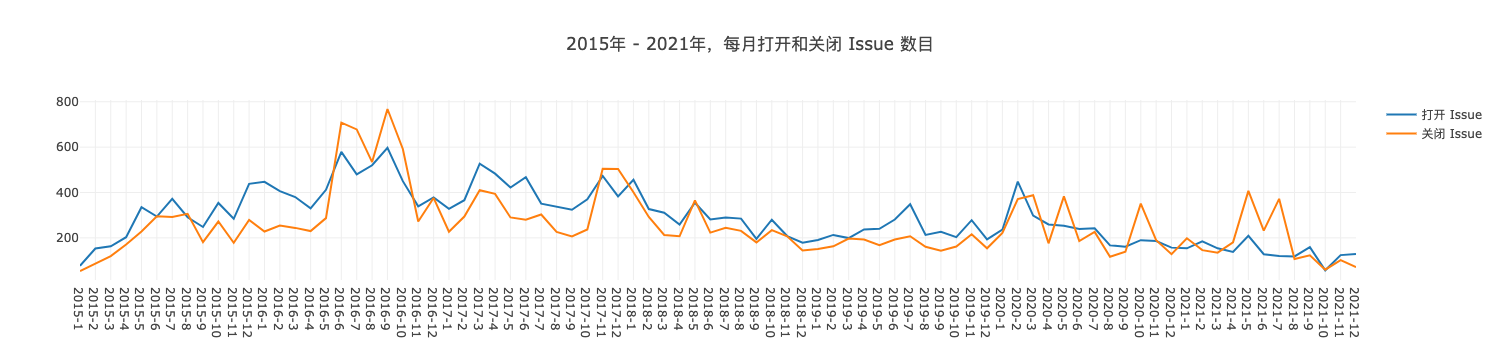

┌─────────┬───────────┬─────────────────┬─────────────────┐
│ (index) │   时间    │ 打开 Issue 数目 │ 关闭 Issue 数目 │
├─────────┼───────────┼─────────────────┼─────────────────┤
│    0    │ '2015-1'  │       77        │       54        │
│    1    │ '2015-2'  │       153       │       88        │
│    2    │ '2015-3'  │       163       │       120       │
│    3    │ '2015-4'  │       203       │       171       │
│    4    │ '2015-5'  │       335       │       228       │
│    5    │ '2015-6'  │       294       │       295       │
│    6    │ '2015-7'  │       372       │       292       │
│    7    │ '2015-8'  │       291       │       306       │
│    8    │ '2015-9'  │       248       │       181       │
│    9    │ '2015-10' │       354       │       272       │
│   10    │ '2015-11' │       284       │       178       │
│   11    │ '2015-12' │       438       │       279       │
│   12    │ '2016-1'  │       447       │       228       │
│   13    │ '2016-2'  │       406       │       25

In [4]:
query (
    `
    select t1.time as time1, t2.time as time2, open_issues_number, close_issues_number
    from 
    (select count(issue_id) as open_issues_number,
    concat(toString(toYear(created_at)),'-',toString(toMonth(created_at))) as time
    from github_log.events
    where repo_id=${my_repo_id} and type = 'IssuesEvent' and action in('opened','reopened') and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by toYear(created_at),toMonth(created_at)
    order by toYear(created_at),toMonth(created_at)) t1
    
    FULL OUTER JOIN
    
    (select count(issue_id) as close_issues_number,
    concat(toString(toYear(created_at)),'-',toString(toMonth(created_at))) as time
    from github_log.events
    where repo_id=${my_repo_id} and type = 'IssuesEvent' and action in('closed') and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by toYear(created_at),toMonth(created_at)
    order by toYear(created_at),toMonth(created_at)) t2
    
    ON t1.time=t2.time
    `
).then(data => {
    // console.log(data)
    var open_issues_number = [], close_issues_number=[], time = [], tt = [];
    data.forEach(d => {
        open_issues_number.push(parseInt(d.open_issues_number));
        close_issues_number.push(parseInt(d.close_issues_number));
         if (d.time1!='') {
            time.push(d.time1);
            tt.push({'时间':d.time1, '打开 Issue 数目':parseInt(d.open_issues_number), '关闭 Issue 数目':parseInt(d.close_issues_number)});
         }
         else {
            time.push(d.time2);
            tt.push({'时间':d.time2, '打开 Issue 数目':parseInt(d.open_issues_number), '关闭 Issue 数目':parseInt(d.close_issues_number)});
         }
});
    // openDigger.render.plotly(
    //     [{x: time, y: stars, type:'bar', name:'打开 Issue'}, {x: time, y: forks, type:'bar', name:'关闭 Issue'}], {
    //     title: '2015年 - 归档期间，每月打开和关闭 Issue 数目',
    //     xaxis: {type: 'category'}
    // });
    openDigger.render.plotly([
        {x: time, y: open_issues_number, mode:'scatter', name:'打开 Issue'}, 
        {x: time, y: close_issues_number, mode:'scatter', name:'关闭 Issue'}
    ], {
        title: '2015年 - 2021年，每月打开和关闭 Issue 数目',
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 3 每月打开 PR 和合入 PR 的个数

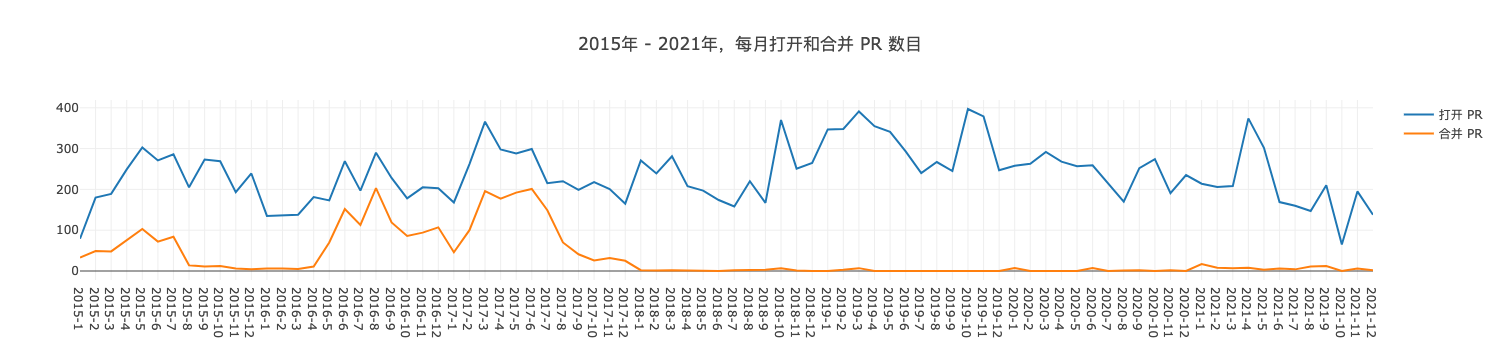

┌─────────┬───────────┬──────────────┬──────────────┐
│ (index) │   时间    │ 打开 PR 数目 │ 合并 PR 数目 │
├─────────┼───────────┼──────────────┼──────────────┤
│    0    │ '2015-1'  │      79      │      33      │
│    1    │ '2015-2'  │     180      │      49      │
│    2    │ '2015-3'  │     189      │      48      │
│    3    │ '2015-4'  │     249      │      76      │
│    4    │ '2015-5'  │     303      │     103      │
│    5    │ '2015-6'  │     271      │      72      │
│    6    │ '2015-7'  │     286      │      84      │
│    7    │ '2015-8'  │     205      │      14      │
│    8    │ '2015-9'  │     273      │      11      │
│    9    │ '2015-10' │     269      │      12      │
│   10    │ '2015-11' │     193      │      6       │
│   11    │ '2015-12' │     239      │      4       │
│   12    │ '2016-1'  │     135      │      6       │
│   13    │ '2016-2'  │     137      │      6       │
│   14    │ '2016-3'  │     138      │      5       │
│   15    │ '2016-4'  │     181      │

In [5]:
query (
    `
    select t1.time as time1, t2.time as time2, open_PR_number, merge_PR_number
    from 
    (select count(issue_id) as open_PR_number,
    concat(toString(toYear(created_at)),'-',toString(toMonth(created_at))) as time
    from github_log.events
    where repo_id=${my_repo_id} and type = 'PullRequestEvent' and action in('opened','reopened') and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by toYear(created_at),toMonth(created_at)
    order by toYear(created_at),toMonth(created_at)) t1
    
    FULL OUTER JOIN
    
    (select count(issue_id) as merge_PR_number,
    concat(toString(toYear(created_at)),'-',toString(toMonth(created_at))) as time
    from github_log.events
    where repo_id=${my_repo_id} and type = 'PullRequestEvent' and action in('closed') and pull_merged=1 and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by toYear(created_at),toMonth(created_at)
    order by toYear(created_at),toMonth(created_at)) t2
    
    ON t1.time=t2.time
    `
).then(data => {
    // console.log(data)
    var open_PR_number = [], merge_PR_number=[], time = [], tt = [];
    data.forEach(d => {
        // console.log(d.time1,typeof(d.time1));
        // console.log(d.time2,typeof(d.time2));
        open_PR_number.push(parseInt(d.open_PR_number));
        merge_PR_number.push(parseInt(d.merge_PR_number));
        if (d.time1!='') {
            time.push(d.time1);
            tt.push({'时间':d.time1, '打开 PR 数目':parseInt(d.open_PR_number), '合并 PR 数目':parseInt(d.merge_PR_number)});
        }
        else {
            time.push(d.time2);
            tt.push({'时间':d.time2, '打开 PR 数目':parseInt(d.open_PR_number), '合并 PR 数目':parseInt(d.merge_PR_number)});
        }        
    });
    // openDigger.render.plotly(
    //     [{x: time, y: stars, type:'bar', name:'打开 PR'}, {x: time, y: forks, type:'bar', name:'合并 PR'}], {
    //     title: '2015年 - 归档期间，每月打开和合并 PR 数目',
    //     xaxis: {type: 'category'}
    // });
    openDigger.render.plotly([
        {x: time, y: open_PR_number, mode:'scatter', name:'打开 PR'}, 
        {x: time, y: merge_PR_number, mode:'scatter', name:'合并 PR'}
    ], {
        title: '2015年 - 2021年，每月打开和合并 PR 数目',
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 4 每月在仓库中活跃（只要有日志产生就算）的不同开发者总数

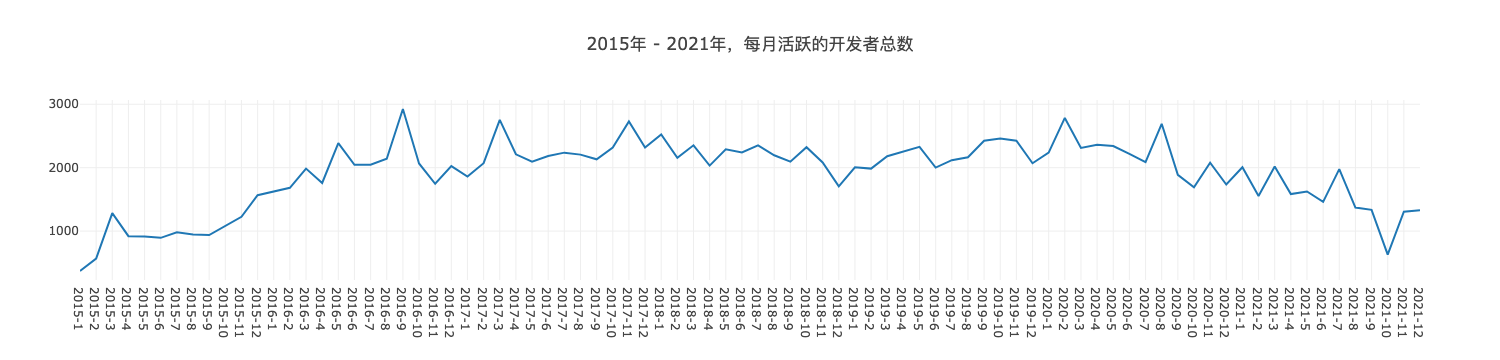

┌─────────┬───────────┬──────────────────┐
│ (index) │   时间    │ 活跃的开发者总数 │
├─────────┼───────────┼──────────────────┤
│    0    │ '2015-1'  │       371        │
│    1    │ '2015-2'  │       566        │
│    2    │ '2015-3'  │       1283       │
│    3    │ '2015-4'  │       920        │
│    4    │ '2015-5'  │       913        │
│    5    │ '2015-6'  │       894        │
│    6    │ '2015-7'  │       980        │
│    7    │ '2015-8'  │       947        │
│    8    │ '2015-9'  │       937        │
│    9    │ '2015-10' │       1078       │
│   10    │ '2015-11' │       1226       │
│   11    │ '2015-12' │       1565       │
│   12    │ '2016-1'  │       1621       │
│   13    │ '2016-2'  │       1683       │
│   14    │ '2016-3'  │       1986       │
│   15    │ '2016-4'  │       1759       │
│   16    │ '2016-5'  │       2388       │
│   17    │ '2016-6'  │       2046       │
│   18    │ '2016-7'  │       2047       │
│   19    │ '2016-8'  │       2141       │
│   20    │ '2016-9' 

In [6]:
query (
    `
    select count(distinct actor_id) as active_user_number,
    concat(toString(toYear(created_at)),'-',toString(toMonth(created_at))) as time
    from github_log.events
    where repo_id=${my_repo_id} and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by toYear(created_at),toMonth(created_at)
    order by toYear(created_at),toMonth(created_at)
    `
).then(data => {
    var active_user_number = [], time = [], tt = [];
    data.forEach(d => {
        active_user_number.push(parseInt(d.active_user_number));
        time.push(d.time);
        tt.push({'时间':d.time,'活跃的开发者总数':parseInt(d.active_user_number)});
    });
    openDigger.render.plotly(
        [{x: time, y: active_user_number, mode:"sactter"}], {
        title: '2015年 - 2021年，每月活跃的开发者总数',
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 5 Issue 从打开到关闭的平均时长和中位数（单位：天)

In [14]:
query(
    ` 
    select avg(dateDiff('hour',issue_created_at,issue_closed_at)) as avg_time,
    median(dateDiff('hour',issue_created_at,issue_closed_at)) as median_time
    from github_log.events 
    where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed' and created_at < toDate('2022-01-01','yyyy-MM-dd')
    `
     ).then(res=>{
    console.log('Issues 从打开到关闭的平均时长：',(res[0].avg_time/24).toFixed(2),'天');
    console.log('Issues 从打开到关闭的时长中位数：',(res[0].median_time/24).toFixed(2),'天');
});

Issues 从打开到关闭的平均时长： 126.25 天
Issues 从打开到关闭的时长中位数： 4.58 天


## 6 PR 从打开到合入的平均时长和中位数（单位：天）

In [8]:
query(
    ` 
    select avg(dateDiff('hour',issue_created_at,pull_merged_at)) as avg_time,
    median(dateDiff('hour',issue_created_at,pull_merged_at)) as median_time
    from github_log.events 
    where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1 and created_at < toDate('2022-01-01','yyyy-MM-dd')
    `
     ).then(res=>{
    console.log('PR 从打开到合入的平均时长：',(res[0].avg_time/24).toFixed(2),'天');
    console.log('PR 从打开到合入的时长中位数：',(res[0].median_time/24).toFixed(2),'天');
});
// 可以看出，之后提交的大部分PR都被关闭，而不是合入

PR 从打开到合入的平均时长： 4.33 天
PR 从打开到合入的时长中位数： 0.83 天


## 7 Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [9]:
query(
    ` 
    select avg(min_comment_time) as avg_min_comment_time, median(min_comment_time) as median_min_comment_time
    from(
    select min(dateDiff('hour',issue_created_at,issue_comment_created_at)) as min_comment_time
    from github_log.events 
    where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created' and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by issue_id
    )
    
    `
     ).then(res=>{
    console.log('Issue 从打开到第一次有人回复的平均时长：',(res[0].avg_min_comment_time/24).toFixed(2),'天');
    console.log('Issue 从打开到第一次有人回复的时长中位数：',(res[0].median_min_comment_time/24).toFixed(2),'天');
});

Issue 从打开到第一次有人回复的平均时长： 101.88 天
Issue 从打开到第一次有人回复的时长中位数： 0.21 天


In [10]:
query(
    ` 
    select avg(min_comment_time) as avg_min_comment_time, median(min_comment_time) as median_min_comment_time
    from(
    select min(dateDiff('hour',issue_created_at,pull_review_comment_created_at)) as min_comment_time
    from github_log.events 
    where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created' and created_at < toDate('2022-01-01','yyyy-MM-dd')
    group by issue_id
    )
    
    `
     ).then(res=>{
    console.log('PR 从打开到第一次有人回复的平均时长：',(res[0].avg_min_comment_time/24).toFixed(2),'天');
    console.log('PR 从打开到第一次有人回复的时长中位数：',(res[0].median_min_comment_time/24).toFixed(2),'天');
});

PR 从打开到第一次有人回复的平均时长： 8.17 天
PR 从打开到第一次有人回复的时长中位数： 0.33 天
